In [40]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
base_data = pd.read_csv("data/raw/base_hand_data.csv").set_index("hand")
blocker_data = pd.read_csv("data/raw/preflop_block_data.csv").set_index('hand')
ev_data = pd.read_csv('data/raw/ev_pca_data.csv').set_index('hand').filter(regex="play")
equity_data = pd.read_csv("data/processed/equity_totals.csv").set_index("hand")
from poker_utils.model import prob_embeddings, analyze_embeddings

In [42]:
full_data = pd.concat(
    [base_data, 
     blocker_data, 
     equity_data, 
     ev_data], axis=1)

In [43]:
cols = [
    'suited', 'connectedness', 'pair', 'high_card', 'low_card',
    'rank_diff', 'ace', 'broadway', 'low_pair', 'medium_pair',
    'high_pair', 'broadway_score', 'suited_broadway',
    'suited_broadway_score', 'connector', 'one_gap', 'two_gap',
    'suited_connector', 'suited_one_gap', 'suited_two_gap',
    'connectedness_score', 'rank_diff_score', 'high_card_score',
    'low_card_score', 'suited_connected_score',
       
    'block_aa', 'block_kk', 'block_qq', 'block_ak', 'block_aq',
    'prem_blocker_score', 'prem_blocker_score_norm', 'block_aa_score',
    'block_kk_score',
       
    'tot_win_perc', 'high_card_win_perc',
    'one_pair_win_perc', 'two_pair_win_perc', 'three_of_a_kind_win_perc',
    'straight_win_perc', 'flush_win_perc', 'full_house_win_perc',
    'four_of_a_kind_win_perc', 'straight_flush_win_perc',
    'straight_win_potential', 'flush_win_potential', 'value_win_potential',
    'highcard_win_potential',
       
    'BB_play10', 'BB_play2', 'BB_play3', 'BB_play4', 'BB_play5', 'BB_play6',
    'BB_play7', 'BB_play8', 'BB_play9', 'D_play10', 'D_play3', 'D_play4',
    'D_play5', 'D_play6', 'D_play7', 'D_play8', 'D_play9', 'SB_play10',
    'SB_play2', 'SB_play3', 'SB_play4', 'SB_play5', 'SB_play6', 'SB_play7',
    'SB_play8', 'SB_play9', 'pos3_play10', 'pos3_play4', 'pos3_play5',
    'pos3_play6', 'pos3_play7', 'pos3_play8', 'pos3_play9', 'pos4_play10',
    'pos4_play5', 'pos4_play6', 'pos4_play7', 'pos4_play8', 'pos4_play9',
    'pos5_play10', 'pos5_play6', 'pos5_play7', 'pos5_play8', 'pos5_play9',
    'pos6_play10', 'pos6_play7', 'pos6_play8', 'pos6_play9', 'pos7_play10',
    'pos7_play8', 'pos7_play9', 'pos8_play10', 'pos8_play9', 'pos9_play10'
]

In [44]:
scaler = StandardScaler()

In [45]:
X = full_data[cols].to_numpy()
X_scaled = scaler.fit_transform(X)

In [46]:
pca = PCA(n_components=16)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
X_pca_norm = normalize(X_pca, norm='l2')

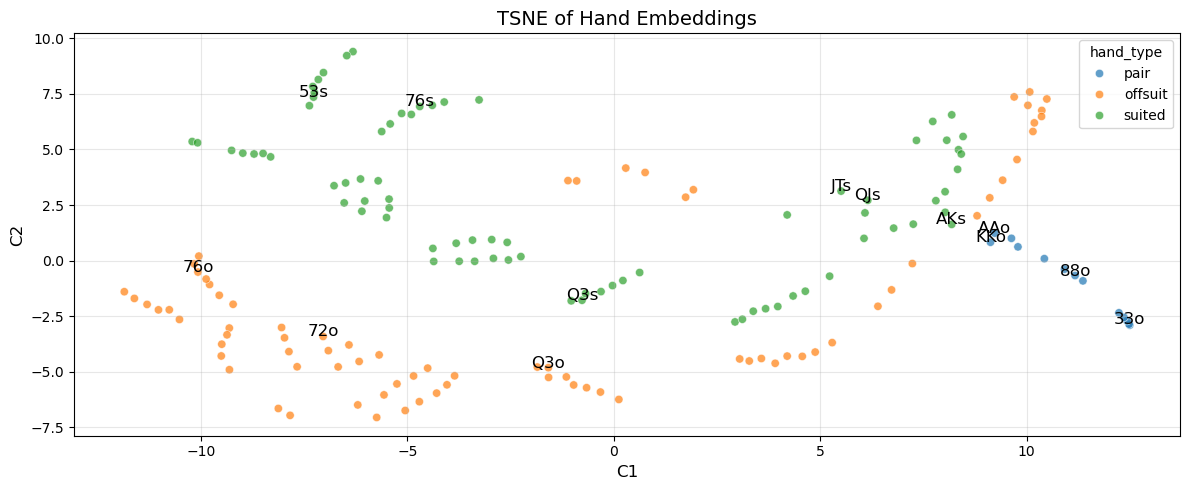

   hand         top_1         top_2         top_3       bottom_1  \
0   AAo  KKo (0.9816)  QQo (0.9668)  JJo (0.9298)  T4s (-0.6798)   
1   KKo  AAo (0.9816)  QQo (0.9683)  JJo (0.9525)  T4s (-0.6786)   
2   72o  83o (0.9864)  82o (0.9831)  62o (0.9677)  KJs (-0.7471)   
3   76s  87s (0.9915)  65s (0.9900)  54s (0.9808)  A7o (-0.4917)   
4   76o  65o (0.9924)  87o (0.9872)  54o (0.9761)  A8s (-0.6610)   
5   Q3s  Q2s (0.9940)  Q4s (0.9932)  Q5s (0.9689)  JJo (-0.4911)   
6   Q3o  Q2o (0.9959)  Q4o (0.9942)  Q5o (0.9730)  KJs (-0.4995)   
7   88o  77o (0.9821)  99o (0.9811)  TTo (0.8823)  T3s (-0.4814)   
8   JTs  T9s (0.9029)  QJs (0.8941)  KQs (0.7117)  82o (-0.6465)   
9   33o  22o (0.9987)  44o (0.9953)  55o (0.9826)  A5s (-0.4205)   
10  AKs  AKo (0.9182)  AQs (0.9054)  KQs (0.9027)  84o (-0.7709)   
11  53s  64s (0.9970)  75s (0.9819)  42s (0.9778)  A9o (-0.5672)   
12  QJs  JTs (0.8941)  KQs (0.8889)  QTs (0.7507)  82o (-0.7492)   

         bottom_2       bottom_3  
0   T5s (-0.

In [47]:
similarity_df = analyze_embeddings(
    X_pca_norm, 
    hands_of_interest=['AAo','KKo','72o','76s','76o','Q3s',"Q3o",'88o','JTs','33o',"AKs","53s","QJs"],
    hand_feature_to_color='hand_type',
    figsize=(12,5)
    )

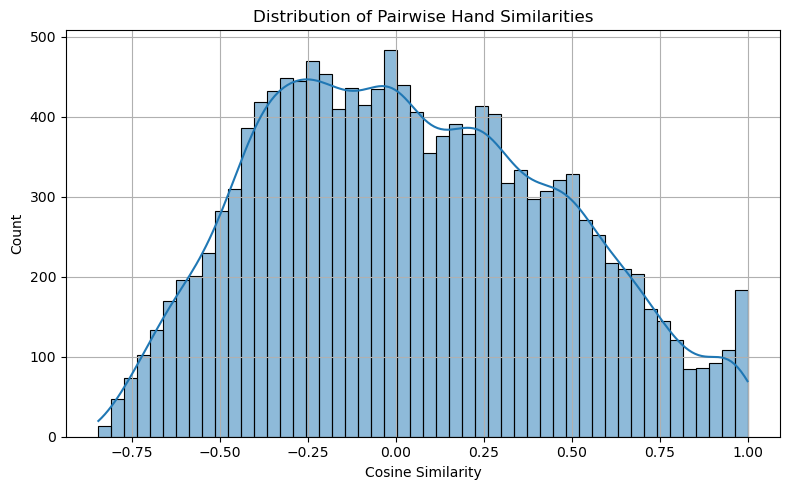

In [48]:
mask = np.triu(np.ones(similarity_df.shape), k=1).astype(bool)
pairwise_sims = similarity_df.where(mask)
all_similarities = pairwise_sims.stack().values

plt.figure(figsize=(8, 5))
sns.histplot(all_similarities, bins=50, kde=True)
plt.title("Distribution of Pairwise Hand Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
prob_data = pd.read_csv('data/processed/prob_data.csv')

In [50]:
prob_res = prob_embeddings(X_pca_norm, prob_data)

In [ ]:
# prob_res.to_csv("results/prob_preflop_pca16.csv", index=False)
# similarity_df.reset_index().rename({"index":'hand'},axis=1).to_csv("results/sim_preflop_pca16.csv")